# Tow_matters PiCar

In [2]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten,Dropout, BatchNormalization, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
from tensorflow_addons.metrics import RSquare

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load csv file 
df = pd.read_csv('../datasets/PiCar/training_norm.csv', index_col=False)
df.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [4]:
df.shape

(13793, 3)

In [5]:
#df = df.drop('image_id', axis=1)
#df.head()

In [6]:
df['angle'].value_counts()

0.7500    2123
0.5000    2046
0.6875    2007
0.6250    1963
0.5625    1609
0.4375    1467
0.8125    1147
0.3750     428
0.8750     301
0.3125     213
0.2500     104
0.1250      99
0.1875      98
0.9375      65
0.0000      60
1.0000      35
0.0625      28
Name: angle, dtype: int64

In [7]:
a = df['image_id'].tolist()
b = [x for x in range(a[0], a[-1] + 1)]
missing_vals = list(set(a) ^ set(b))
print('Missing data:', missing_vals)

Missing data: [3141, 3999, 4895, 8285, 10171]


In [8]:
images_dir = '../datasets/PiCar/train/training_data'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/10171.png']



images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,13793
unique,13793
top,../datasets/PiCar/train/training_data/2586.png
freq,1


In [9]:
df_all = pd.concat([df, images], axis=1)
df_all = df_all.drop('image_id', axis=1)
df_all.tail()

,angle,speed,images
13788,0.6250,1.0,../datasets/PiCar/train/training_data/13794.png
13789,0.4375,1.0,../datasets/PiCar/train/training_data/13795.png
13790,0.5625,0.0,../datasets/PiCar/train/training_data/13796.png
13791,0.6250,0.0,../datasets/PiCar/train/training_data/13797.png
13792,0.6875,1.0,../datasets/PiCar/train/training_data/13798.png


In [10]:
df_all.shape

(13793, 3)

In [11]:
#le = LabelEncoder()
#df_all['angle']= le.fit_transform(df_all['angle'])
#df_all.head()

image_path: ../datasets/PiCar/train/training_data/11.png
steering_Angle: 0.6875
Speed: 0.0


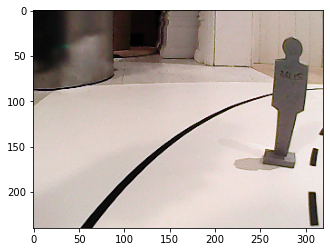

In [12]:
image_paths = df_all['images'].tolist()
steering_angles = df_all['angle'].tolist()
speed = df_all['speed'].tolist()


image_index = 10
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index]) 
print("steering_Angle:", steering_angles[image_index]) 
print("Speed:", speed[image_index]) 


In [13]:
X_train, X_valid = train_test_split( df_all, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))



Training data: 11034
Validation data: 2759


In [14]:
class Nvidia_CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()
    
    self.conv1 = Conv2D(24, 5,strides=(2, 2), activation='relu')
    self.conv2 = Conv2D(36, 5, strides=(2, 2),activation='relu')
    self.conv3 = Conv2D(48, 5, strides=(2, 2),activation='relu')
    self.conv4 = Conv2D(64, 3, strides=(2, 2), activation='relu')
    #self.drop1 = Dropout(0.25)
    self.batch1 = BatchNormalization()
    self.conv5 = Conv2D(64, 3, strides=(2, 2),activation='relu')
    
    self.flatten = Flatten()
    self.drop2 = Dropout(0.25)
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(64, activation='relu')
    self.d3 = Dense(32, activation='relu')
    #self.d4 = Dense(16, activation='relu')
    
    self.Y1 = Dense(1, activation='relu')    
    self.Y2 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    #x = self.drop1(x)
    x = self.batch1(x)
    x = self.conv5(x)
    
    x = self.flatten(x)
    x = self.drop2(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    #x = self.d4(x)
    
    
    y1 = self.Y1(x)
    y2 = self.Y2(x)
    
    return y1,y2

In [15]:
model = Nvidia_CNN()
model.build((1,240, 180, 3))
model.summary()

Model: "nvidia_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1824      
                                                                 
 conv2d_1 (Conv2D)           multiple                  21636     
                                                                 
 conv2d_2 (Conv2D)           multiple                  43248     
                                                                 
 conv2d_3 (Conv2D)           multiple                  27712     
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           multiple                  36928     
                                                        

In [15]:
tf.keras.backend.clear_session()

# Early stop added
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

train_gen = ImageDataGenerator(rescale=1./255,width_shift_range=0.1, height_shift_range=0.1)
val_gen = ImageDataGenerator(rescale=1./255)

model = Nvidia_CNN()


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss={
        "output_1" : tf.keras.losses.MeanSquaredError(),
        "output_2" : tf.keras.losses.BinaryCrossentropy(from_logits=False)},
        metrics={"output_1": [RSquare()], "output_2": 'accuracy'})


history= model.fit(train_gen.flow_from_dataframe(X_train,x_col='images',y_col=['angle','speed'],class_mode='multi_output',
                                        target_size=(240,180),batch_size=32),
    validation_data=val_gen.flow_from_dataframe(X_valid, x_col='images',y_col=['angle','speed'],class_mode='multi_output',
    target_size=(240,180),batch_size=32), callbacks= [callback], epochs=80)

model.save('model/Nvidia_CNN',save_format='tf')

Found 11034 validated image filenames.
Found 2759 validated image filenames.
Epoch 1/80
345/345 [==============================] - 107s 307ms/step - loss: 0.4879 - output_1_loss: 0.0441 - output_2_loss: 0.4438 - output_1_r_square: -0.8253 - output_2_accuracy: 0.8147 - val_loss: 0.4687 - val_output_1_loss: 0.1260 - val_output_2_loss: 0.3427 - val_output_1_r_square: -4.1617 - val_output_2_accuracy: 0.8695
Epoch 2/80
345/345 [==============================] - 101s 293ms/step - loss: 0.2650 - output_1_loss: 0.0308 - output_2_loss: 0.2342 - output_1_r_square: -0.2767 - output_2_accuracy: 0.9148 - val_loss: 0.3961 - val_output_1_loss: 0.0477 - val_output_2_loss: 0.3484 - val_output_1_r_square: -0.9546 - val_output_2_accuracy: 0.8539
Epoch 3/80
345/345 [==============================] - 101s 292ms/step - loss: 0.2070 - output_1_loss: 0.0241 - output_2_loss: 0.1830 - output_1_r_square: 0.0027 - output_2_accuracy: 0.9322 - val_loss: 0.2889 - val_output_1_loss: 0.0199 - val_output_2_loss: 0.2689

Epoch 26/80
345/345 [==============================] - 100s 288ms/step - loss: 0.0778 - output_1_loss: 0.0104 - output_2_loss: 0.0674 - output_1_r_square: 0.5698 - output_2_accuracy: 0.9722 - val_loss: 0.1028 - val_output_1_loss: 0.0109 - val_output_2_loss: 0.0919 - val_output_1_r_square: 0.5542 - val_output_2_accuracy: 0.9605
Epoch 27/80
345/345 [==============================] - 99s 285ms/step - loss: 0.0732 - output_1_loss: 0.0104 - output_2_loss: 0.0628 - output_1_r_square: 0.5698 - output_2_accuracy: 0.9745 - val_loss: 0.0838 - val_output_1_loss: 0.0131 - val_output_2_loss: 0.0707 - val_output_1_r_square: 0.4634 - val_output_2_accuracy: 0.9775
Epoch 28/80
345/345 [==============================] - 99s 287ms/step - loss: 0.0716 - output_1_loss: 0.0105 - output_2_loss: 0.0612 - output_1_r_square: 0.5655 - output_2_accuracy: 0.9761 - val_loss: 0.1011 - val_output_1_loss: 0.0150 - val_output_2_loss: 0.0861 - val_output_1_r_square: 0.3840 - val_output_2_accuracy: 0.9746
Epoch 29/80
345

Epoch 51/80
345/345 [==============================] - 102s 295ms/step - loss: 0.0521 - output_1_loss: 0.0089 - output_2_loss: 0.0431 - output_1_r_square: 0.6296 - output_2_accuracy: 0.9840 - val_loss: 0.0693 - val_output_1_loss: 0.0089 - val_output_2_loss: 0.0603 - val_output_1_r_square: 0.6336 - val_output_2_accuracy: 0.9819
Epoch 52/80
345/345 [==============================] - 102s 295ms/step - loss: 0.0489 - output_1_loss: 0.0090 - output_2_loss: 0.0399 - output_1_r_square: 0.6277 - output_2_accuracy: 0.9839 - val_loss: 0.0656 - val_output_1_loss: 0.0108 - val_output_2_loss: 0.0548 - val_output_1_r_square: 0.5556 - val_output_2_accuracy: 0.9757
Epoch 53/80
345/345 [==============================] - 101s 292ms/step - loss: 0.0479 - output_1_loss: 0.0088 - output_2_loss: 0.0391 - output_1_r_square: 0.6360 - output_2_accuracy: 0.9850 - val_loss: 0.0515 - val_output_1_loss: 0.0083 - val_output_2_loss: 0.0431 - val_output_1_r_square: 0.6585 - val_output_2_accuracy: 0.9862
Epoch 54/80
3

INFO:tensorflow:Assets written to: model/Nvidia_CNN/assets


INFO:tensorflow:Assets written to: model/Nvidia_CNN/assets


In [16]:
def plots(history):
    # summarize history for accuracy
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(10,6))
    
    ax1.set_title('Angle R Squared')
    ax1.plot(history.history['output_1_r_square'])
    ax1.plot(history.history['val_output_1_r_square'])
    ax1.set_yscale('log')
    ax1.legend(['train', 'test'], loc='lower right')
    
    ax2.set_title('Speed Accuracy')
    ax2.plot(history.history['output_2_accuracy'])
    ax2.plot(history.history['val_output_2_accuracy'])
    ax2.set_yscale('log')
    ax2.legend(['train', 'test'], loc='lower right')
    
    # summarize history for loss
    ax3.set_title('Angle MSE loss')  
    ax3.plot(history.history['output_1_loss'])
    ax3.plot(history.history['val_output_1_loss'])
    ax3.set_yscale('log')
    ax3.legend(['train', 'test'], loc='upper right')
   
    ax4.set_title('Speed loss')
    ax4.plot(history.history['output_2_loss'])
    ax4.plot(history.history['val_output_2_loss'])
    ax4.set_yscale('log')
    ax4.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

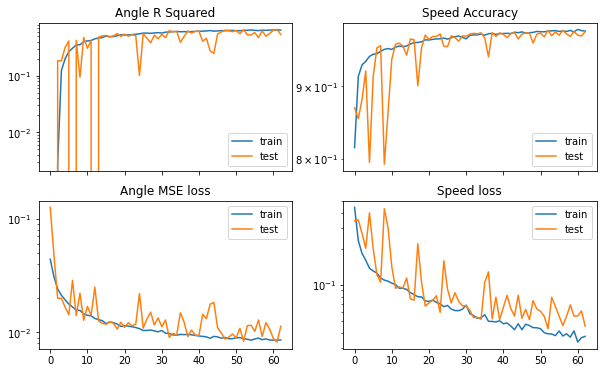

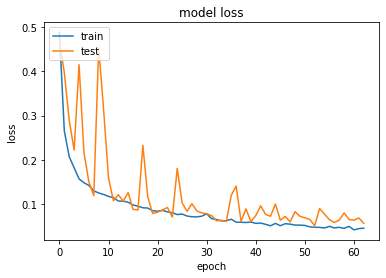

In [17]:
plots(history)


# Evaluation using validation set

In [22]:
predict_val = model.predict(val_gen.flow_from_dataframe(X_valid, x_col='images',y_col=[,'angle','speed'],class_mode='multi_output',
    target_size=(240,180),batch_size=32))

Found 2759 validated image filenames.
87/87 [==============================] - 6s 68ms/step


In [56]:
angles = pd.DataFrame(predict_val[0], columns=['Angle'])
speed = pd.DataFrame(predict_val[1], columns=['speed'])
pred_df = pd.concat([angles, speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df.head()

,image_id,Angle,speed
0,1,0.638353,0.999942
1,2,0.445826,0.000011
2,3,0.700957,0.999579
3,4,0.488266,0.000024
4,5,0.485734,0.999989


In [37]:
pred_df_rnd = pred_df.round({'Angle': 4, 'speed': 0})
pred_df_rnd.head()

,image_id,Angle,speed
0,1,0.6384,1.0
1,2,0.4458,0.0
2,3,0.7010,1.0
3,4,0.4883,0.0
4,5,0.4857,1.0


In [42]:
pred_df_rnd['speed'] = pd.to_numeric(pred_df_rnd['speed'],downcast="integer" )
pred_df_rnd.head()

,image_id,Angle,speed
0,1,0.6384,1
1,2,0.4458,0
2,3,0.7010,1
3,4,0.4883,0
4,5,0.4857,1


In [48]:
X_valid['speed'].dtype

dtype('float64')

In [49]:
X_valid['speed']=X_valid['speed'].astype("int")
X_valid.head()

,angle,speed,images
8510,0.5625,0,../datasets/PiCar/train/training_data/8515.png
11527,0.8125,1,../datasets/PiCar/train/training_data/11533.png
6711,0.8125,1,../datasets/PiCar/train/training_data/6715.png
1921,0.7500,0,../datasets/PiCar/train/training_data/1922.png
12631,0.7500,1,../datasets/PiCar/train/training_data/12637.png


In [50]:
cm = confusion_matrix(X_valid['speed'], pred_df_rnd['speed'])

              precision    recall  f1-score   support

           0       0.22      0.22      0.22       609
           1       0.78      0.78      0.78      2150

    accuracy                           0.66      2759
   macro avg       0.50      0.50      0.50      2759
weighted avg       0.66      0.66      0.66      2759



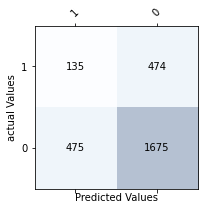

In [51]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
classes=["1", "0"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('actual Values',);
print(classification_report(X_valid['speed'], pred_df_rnd['speed']))


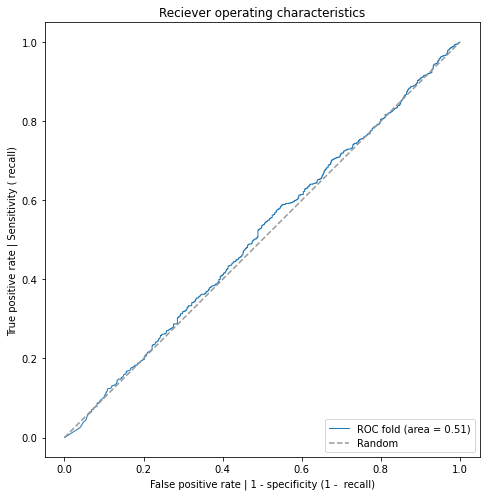

In [57]:
# Plot the rciever opertaing characteristic curve (ROC)
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,8))
#probas_ = model.predict(X_valid['speed'])
fpr, tpr, thresholds = roc_curve(X_valid['speed'], pred_df['speed'])
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr, lw=1, label='ROC fold (area = %0.2f)' %(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate | 1 - specificity (1 -  recall)')
plt.ylabel('True positive rate | Sensitivity ( recall)')
plt.title('Reciever operating characteristics')
plt.legend(loc="lower right")
plt.axes().set_aspect(1);

# Testing

In [18]:
testgen = ImageDataGenerator()

predict = model.predict(val_gen.flow_from_directory('../datasets/PiCar/test',target_size=(240,180)))

Found 1020 images belonging to 1 classes.
32/32 [==============================] - 3s 83ms/step


In [19]:
angles = pd.DataFrame(predict[0], columns=['Angle'])
speed = pd.DataFrame(predict[1], columns=['speed'])
pred_df = pd.concat([angles, speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df

,image_id,Angle,speed
0,1,0.555329,0.000025
1,2,0.483741,0.000435
2,3,0.596318,0.000596
3,4,0.061079,0.999516
4,5,0.652922,0.999799
...,...,...,...
1015,1016,0.000000,0.991730
1016,1017,0.406098,0.001603
1017,1018,0.458745,0.000971
1018,1019,0.677850,1.000000


In [20]:
pred_df = pred_df.round({'Angle': 4, 'speed': 0})
pred_df

,image_id,Angle,speed
0,1,0.5553,0.0
1,2,0.4837,0.0
2,3,0.5963,0.0
3,4,0.0611,1.0
4,5,0.6529,1.0
...,...,...,...
1015,1016,0.0000,1.0
1016,1017,0.4061,0.0
1017,1018,0.4587,0.0
1018,1019,0.6778,1.0


In [44]:
pred_df.to_csv('Tow_mat5.csv', index=False)

## Standalone models

In [13]:
class angle_CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()
    
    self.conv1 = Conv2D(24, 5,strides=(2, 2), activation='relu')
    self.conv2 = Conv2D(36, 5, strides=(2, 2),activation='relu')
    self.conv3 = Conv2D(48, 5, strides=(2, 2),activation='relu')
    self.conv4 = Conv2D(64, 3, strides=(2, 2), activation='relu')
    self.drop1 = Dropout(0.25)
    self.conv5 = Conv2D(64, 3, strides=(2, 2),activation='relu')
    
    self.flatten = Flatten()
    self.drop2 = Dropout(0.25)
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(64, activation='relu')
    self.d3 = Dense(32, activation='relu')
    self.d4 = Dense(16, activation='relu')
    
    self.D4 = Dense(17, activation='softmax')
    #self.D5 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.drop1(x)
    x = self.conv5(x)
    
    x = self.flatten(x)
    x = self.drop2(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = self.d4(x)
    
    y1 = self.D4(x)
    #y2 = self.D5(x)
    
    
    
    return y1

In [14]:
train_gen = ImageDataGenerator(shear_range = 0.2, zoom_range =0.2, rotation_range=20,
                               width_shift_range=0.2, height_shift_range=0.2,brightness_range=[0.4,1.5])
val_gen = ImageDataGenerator()

model = angle_CNN()
#model = CNN().full_model()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(train_gen.flow_from_dataframe(X_train,x_col='images',y_col='angle',class_mode='raw',
                                        target_size=(240,180),batch_size=32),
    validation_data=val_gen.flow_from_dataframe(X_valid, x_col='images',y_col='angle',class_mode='raw',
    target_size=(240,180),batch_size=32), epochs=20)

model.save('model/angle_CNN',save_format='tf')

Found 11034 validated image filenames.
Found 2759 validated image filenames.
Epoch 1/20
345/345 [==============================] - 118s 338ms/step - loss: 2.2410 - accuracy: 0.1878 - val_loss: 1.8291 - val_accuracy: 0.3103
Epoch 2/20
345/345 [==============================] - 115s 332ms/step - loss: 1.9276 - accuracy: 0.2668 - val_loss: 1.7275 - val_accuracy: 0.3240
Epoch 3/20
345/345 [==============================] - 115s 334ms/step - loss: 1.8461 - accuracy: 0.2756 - val_loss: 1.6661 - val_accuracy: 0.3483
Epoch 4/20
345/345 [==============================] - 115s 332ms/step - loss: 1.7911 - accuracy: 0.2877 - val_loss: 1.6862 - val_accuracy: 0.2541
Epoch 5/20
345/345 [==============================] - 115s 333ms/step - loss: 1.7600 - accuracy: 0.2917 - val_loss: 1.6754 - val_accuracy: 0.3117
Epoch 6/20
345/345 [==============================] - 116s 336ms/step - loss: 1.7576 - accuracy: 0.2983 - val_loss: 1.6080 - val_accuracy: 0.3171
Epoch 7/20
345/345 [===========================

INFO:tensorflow:Assets written to: model/angle_CNN/assets


INFO:tensorflow:Assets written to: model/angle_CNN/assets


In [16]:
def singlePlots(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

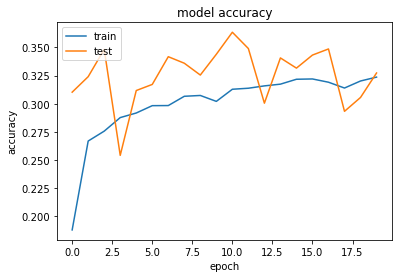

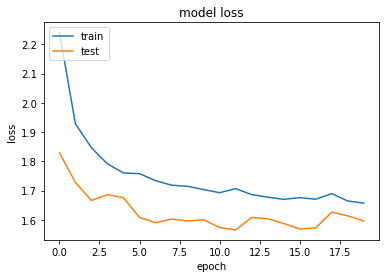

In [17]:
singlePlots(history)

In [25]:
class speed_CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()
    
    self.conv1 = Conv2D(24, 5, activation='relu')
    self.conv2 = Conv2D(36, 5, activation='relu')
    self.conv3 = Conv2D(48, 5, activation='relu')
    self.conv4 = Conv2D(64, 3, activation='relu')
    self.conv5 = Conv2D(64, 3, activation='relu')
    
    self.flatten = Flatten()
    self.d1 = Dense(100, activation='relu')
    self.d2 = Dense(50, activation='relu')
    
    #self.D4 = Dense(17, activation='softmax')
    self.D5 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    
    #y1 = self.D4(x)
    y2 = self.D5(x)
    
    
    
    return y2

In [26]:
train_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

model = speed_CNN()
#model = CNN().full_model()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(train_gen.flow_from_dataframe(X_train,x_col='images',y_col='speed',class_mode='raw',
                                        target_size=(200,66),batch_size=32),
    validation_data=val_gen.flow_from_dataframe(X_valid, x_col='images',y_col='speed',class_mode='raw',
    target_size=(200,66),batch_size=32), epochs=20)

model.save('model/speed_CNN',save_format='tf')

Found 11034 validated image filenames.
Found 2759 validated image filenames.
Epoch 1/20
345/345 [==============================] - 42s 115ms/step - loss: 17.6693 - accuracy: 0.8088 - val_loss: 0.2366 - val_accuracy: 0.9094
Epoch 2/20
345/345 [==============================] - 38s 109ms/step - loss: 0.1520 - accuracy: 0.9446 - val_loss: 0.1328 - val_accuracy: 0.9496
Epoch 3/20
345/345 [==============================] - 37s 106ms/step - loss: 0.0800 - accuracy: 0.9711 - val_loss: 0.1405 - val_accuracy: 0.9496
Epoch 4/20
345/345 [==============================] - 33s 95ms/step - loss: 0.0474 - accuracy: 0.9838 - val_loss: 0.1538 - val_accuracy: 0.9507
Epoch 5/20
345/345 [==============================] - 32s 94ms/step - loss: 0.0343 - accuracy: 0.9876 - val_loss: 0.2297 - val_accuracy: 0.9387
Epoch 6/20
345/345 [==============================] - 42s 123ms/step - loss: 0.0410 - accuracy: 0.9863 - val_loss: 0.2041 - val_accuracy: 0.9456
Epoch 7/20
345/345 [==============================] - 

INFO:tensorflow:Assets written to: model/speed_CNN\assets


INFO:tensorflow:Assets written to: model/speed_CNN\assets
